<a href="https://colab.research.google.com/github/pippahtlin/Extreme-Precipitation/blob/main/pretrained_univariate_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/pippahtlin/Extreme-Precipitation/main/data/precipitation_soi",index_col = "date")
df.index = pd.to_datetime(df.index)
df

,year,month,day,daily rain,binary rain,soi
date,,,,,,
1899-10-11,1899,10,11,3.048000,0,-1
1899-10-12,1899,10,12,2.032000,0,-1
1899-10-13,1899,10,13,33.020000,1,-1
1899-10-14,1899,10,14,0.508000,0,-1
1899-10-15,1899,10,15,0.000000,0,-1
...,...,...,...,...,...,...
2022-12-27,2022,12,27,0.000000,0,1
2022-12-28,2022,12,28,22.859999,0,1
2022-12-29,2022,12,29,0.000000,0,1


In [4]:
# Calculate indices for splitting
total_rows = len(df)
train_end = int(total_rows * 0.6)
validation_end = train_end + int(total_rows * 0.2)

# Using iloc for integer-location based indexing
train = df[["daily rain"]].iloc[:train_end]
validation = df[["daily rain"]].iloc[train_end:validation_end]
test = df[["daily rain"]].iloc[validation_end:]

In [5]:
# upper = 80
sc = MinMaxScaler(feature_range=(0,80))
train_scaled = sc.fit_transform(train)
validation_scaled = sc.transform(validation)
test_scaled = sc.transform(test)

print(type(train_scaled))
train_scaled

"""
# upper = 1
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)
validation_scaled = sc.transform(validation)
test_scaled = sc.transform(test)

print(type(train_scaled))
train_scaled
"""

<class 'numpy.ndarray'>


'\n# upper = 1\nsc = MinMaxScaler(feature_range=(0,1))\ntrain_scaled = sc.fit_transform(train)\nvalidation_scaled = sc.transform(validation)\ntest_scaled = sc.transform(test)\n\nprint(type(train_scaled))\ntrain_scaled\n'

In [6]:
T = 90 # Consider seasonality

# Train
X_train = []
y_train = []
for i in range(T,train_scaled.shape[0]):
    X_train.append(train_scaled[i-T:i])
    y_train.append(train_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)

# Validation
X_validation = []
y_validation = []

for i in range(T, validation_scaled.shape[0]):
    X_validation.append(validation_scaled[i-T:i])
    y_validation.append(validation_scaled[i])
X_validation, y_validation = np.array(X_validation), np.array(y_validation)

X_test = []
y_test = []
for i in range(T, test_scaled.shape[0]):
    X_test.append(test_scaled[i-T:i])
    y_test.append(test_scaled[i])
X_test, y_test = np.array(X_test), np.array(y_test)

# M, T, N
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)

(26914, 90, 1) (26914, 1)
(8911, 90, 1) (8911, 1)
(8912, 90, 1) (8912, 1)


In [8]:
from keras import models
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras import metrics
from time import time

<br>

## Import the pre-trained models on github

### 1. Upper bound 80 + epoch 50:

In [11]:
model = models.load_model('/content/drive/MyDrive/Extreme Precipitation/Models/model_upper80.h5')

In [12]:
validation_predictions = model.predict(X_validation)
validation_predictions = sc.inverse_transform(validation_predictions)
validation_actual = sc.inverse_transform(y_validation.reshape(-1,1))

# Create validation dataset
validation_compare = pd.DataFrame({'Actual': validation_actual.flatten(), 'Predicted': validation_predictions.flatten()})
validation_compare.head(20)

279/279 [==============================] - 6s 20ms/step


,Actual,Predicted
0,0.000,1.637784
1,0.000,1.450884
2,0.000,1.302456
3,0.000,1.139461
4,0.000,0.935978
5,0.000,0.747130
6,4.064,0.622047
7,0.000,2.247009
8,0.000,0.316922
9,0.000,1.623323


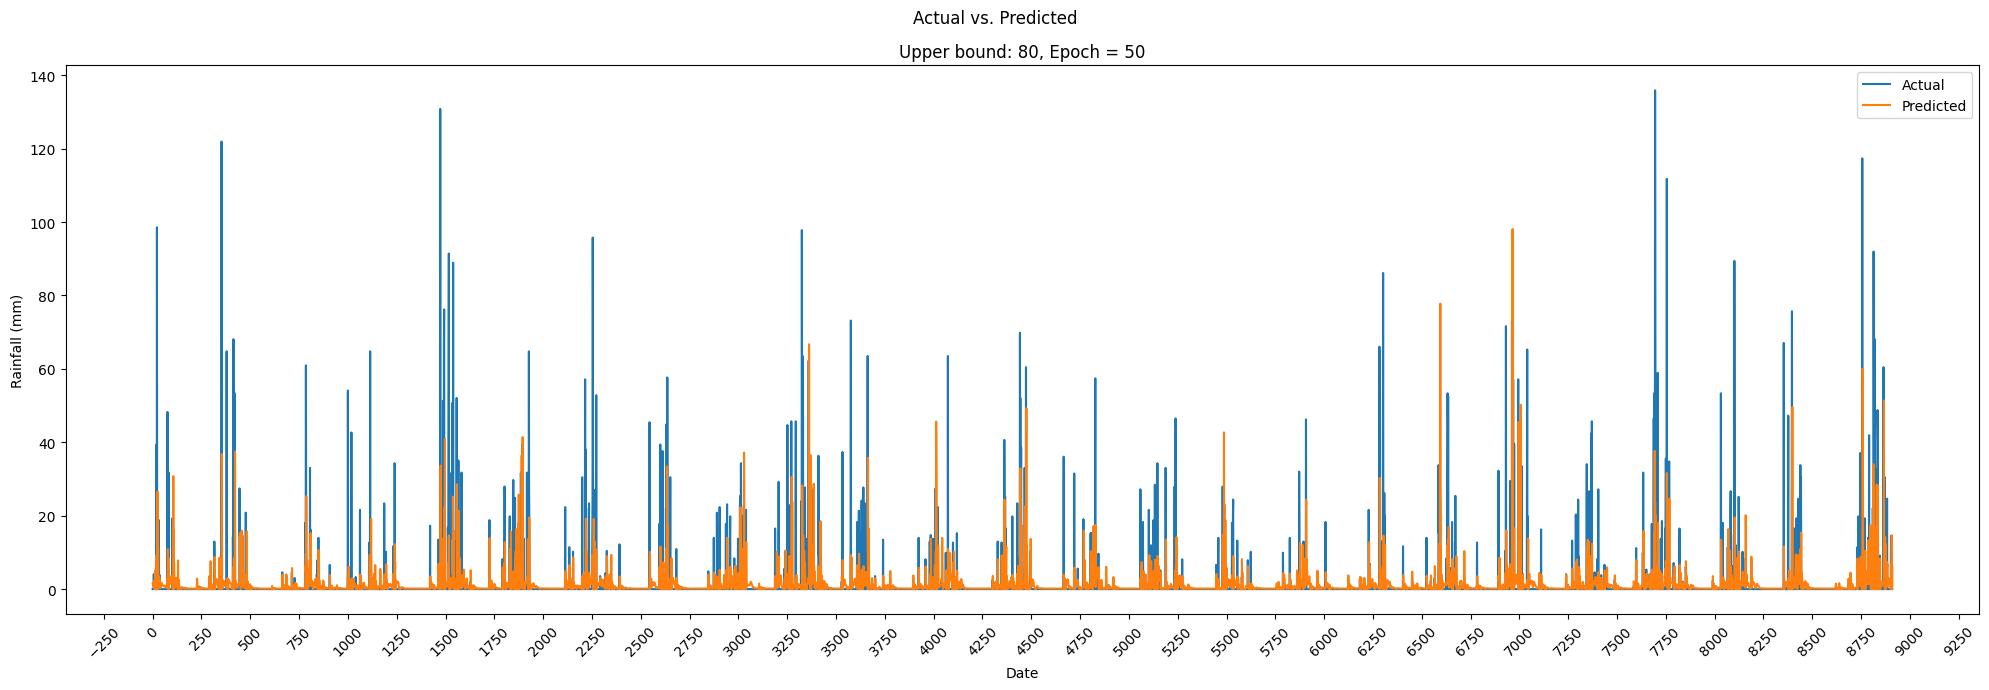

In [13]:
# For upper = 80

# Turn negative prediction to 0
validation_compare['Predicted'] = validation_compare['Predicted'].clip(lower=0)

plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(validation_compare['Actual'])
plt.plot(validation_compare['Predicted'])
plt.legend(['Actual', 'Predicted'])
plt.suptitle("Actual vs. Predicted")
plt.title("Upper bound: 80, Epoch = 50")
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()


plt.show()

In [14]:
eval_valiation = model.evaluate(validation_compare['Actual'],validation_compare['Predicted'])
print(f"Loss: {eval_valiation[0]}")
print(f"MSE: {eval_valiation[1]}")
print(f"AUC: {eval_valiation[2]}")

279/279 [==============================] - 2s 3ms/step - loss: 21.7506 - mean_squared_error: 21.7506 - auc: 0.4865
Loss: 21.750621795654297
MSE: 21.750621795654297
AUC: 0.4865093529224396


In [15]:
test_predictions = model.predict(X_test)
test_predictions = sc.inverse_transform(test_predictions)
test_actual = sc.inverse_transform(y_test.reshape(-1,1))

# Create validation dataset
test_compare = pd.DataFrame({'Actual': test_actual.flatten(), 'Predicted': test_predictions.flatten()})
test_compare.head(20)

279/279 [==============================] - 6s 21ms/step


,Actual,Predicted
0,0.0,0.143047
1,0.0,0.142387
2,0.0,0.151391
3,0.0,0.163596
4,0.0,0.192832
5,0.0,0.187128
6,0.0,0.175539
7,0.0,0.161976
8,0.0,0.151172
9,0.0,0.146446


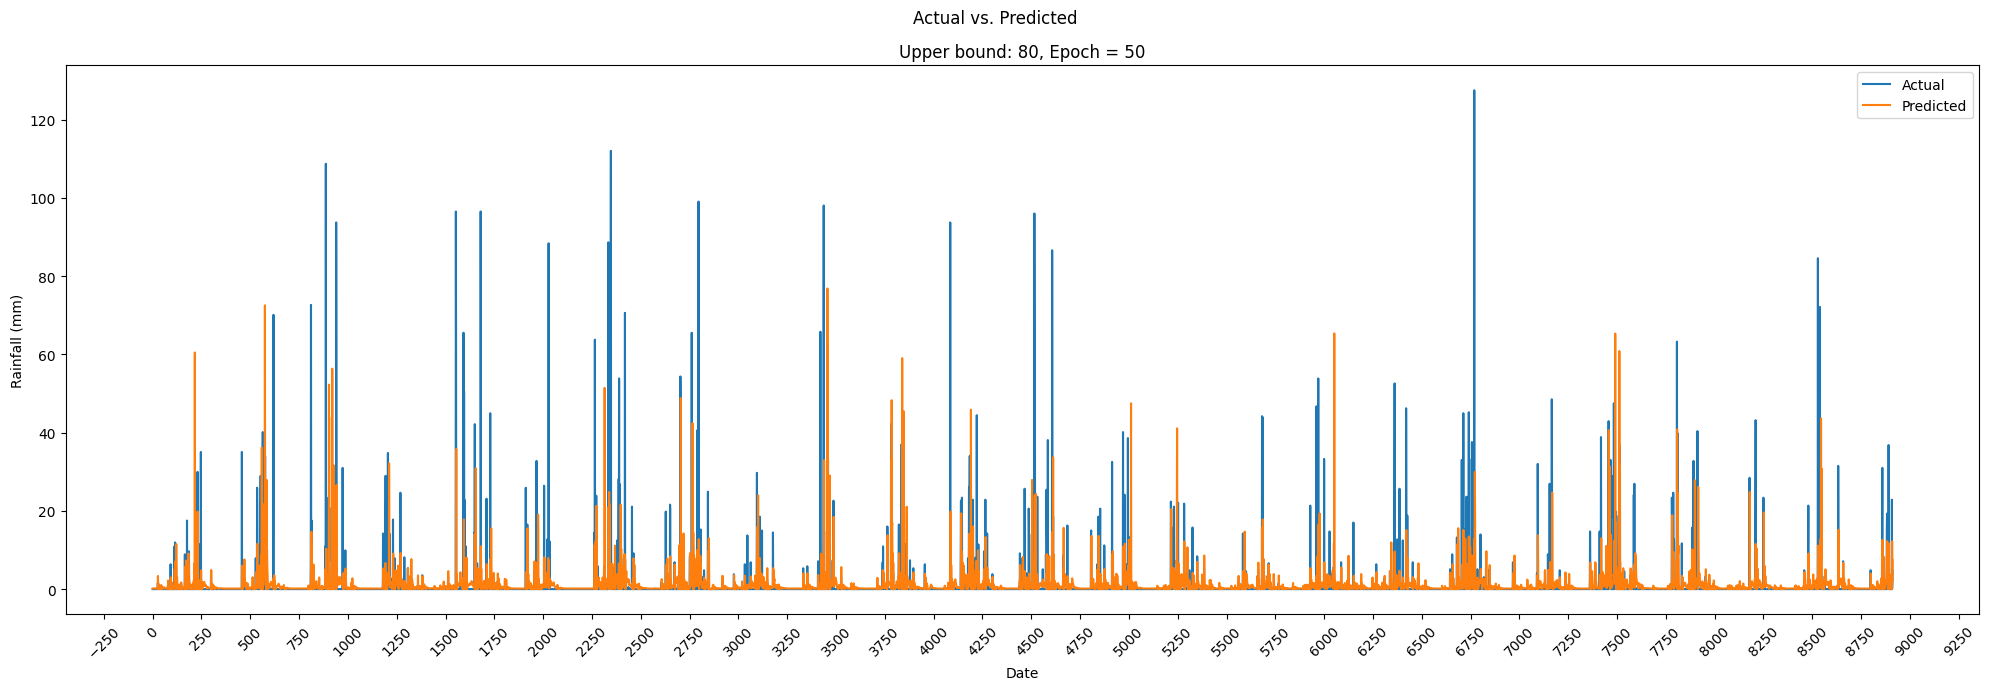

In [16]:
# For upper = 80

# Turn negative prediction to 0
test_compare['Predicted'] = test_compare['Predicted'].clip(lower=0)

plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(test_compare['Actual'])
plt.plot(test_compare['Predicted'])
plt.legend(['Actual', 'Predicted'])
plt.suptitle("Actual vs. Predicted")
plt.title("Upper bound: 80, Epoch = 50")
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()


plt.show()

In [17]:
eval_pred = model.evaluate(test_compare['Actual'],test_compare['Predicted'])
print(f"Loss: {eval_pred[0]}")
print(f"MSE: {eval_pred[1]}")
print(f"AUC: {eval_pred[2]}")

279/279 [==============================] - 1s 2ms/step - loss: 20.4939 - mean_squared_error: 20.4939 - auc: 0.4964
Loss: 20.493896484375
MSE: 20.493896484375
AUC: 0.4964269697666168


<br>

### 2. Upper bound 80 + epoch 30:

In [18]:
model = models.load_model('/content/drive/MyDrive/Extreme Precipitation/Models/model_upper80-epoch30.h5')

In [19]:
validation_predictions = model.predict(X_validation)
validation_predictions = sc.inverse_transform(validation_predictions)
validation_actual = sc.inverse_transform(y_validation.reshape(-1,1))

# Create validation dataset
validation_compare = pd.DataFrame({'Actual': validation_actual.flatten(), 'Predicted': validation_predictions.flatten()})
validation_compare.head(20)

279/279 [==============================] - 8s 27ms/step


,Actual,Predicted
0,0.000,1.039142
1,0.000,0.947331
2,0.000,0.871434
3,0.000,0.807566
4,0.000,0.751668
5,0.000,0.700834
6,4.064,0.654307
7,0.000,4.124908
8,0.000,0.758154
9,0.000,1.497852


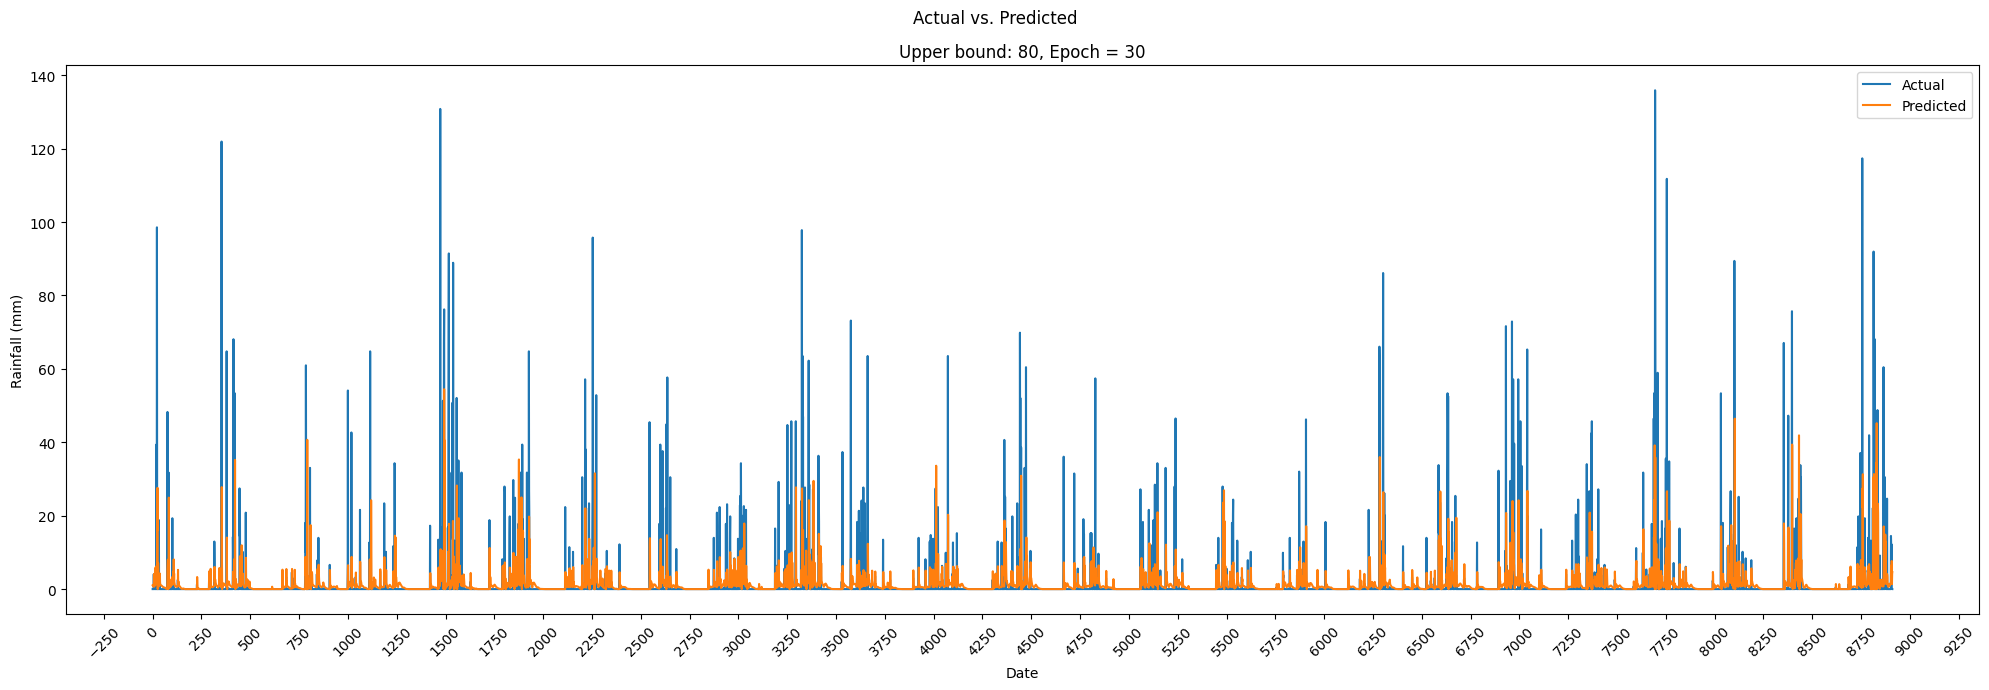

In [20]:
# For upper = 80

# Turn negative prediction to 0
validation_compare['Predicted'] = validation_compare['Predicted'].clip(lower=0)

plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(validation_compare['Actual'])
plt.plot(validation_compare['Predicted'])
plt.legend(['Actual', 'Predicted'])
plt.suptitle("Actual vs. Predicted")
plt.title("Upper bound: 80, Epoch = 30")
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()


plt.show()

In [21]:
eval_valiation = model.evaluate(validation_compare['Actual'],validation_compare['Predicted'])
print(f"Loss: {eval_valiation[0]}")
print(f"MSE: {eval_valiation[1]}")
print(f"AUC: {eval_valiation[2]}")

279/279 [==============================] - 2s 2ms/step - loss: 11.8009 - mean_squared_error: 11.8009 - auc: 0.5502
Loss: 11.800871849060059
MSE: 11.800871849060059
AUC: 0.5502128005027771


In [22]:
test_predictions = model.predict(X_test)
test_predictions = sc.inverse_transform(test_predictions)
test_actual = sc.inverse_transform(y_test.reshape(-1,1))

# Create validation dataset
test_compare = pd.DataFrame({'Actual': test_actual.flatten(), 'Predicted': test_predictions.flatten()})
test_compare.head(20)

279/279 [==============================] - 6s 22ms/step


,Actual,Predicted
0,0.0,-0.006529
1,0.0,-0.014249
2,0.0,-0.019897
3,0.0,-0.025411
4,0.0,-0.021390
5,0.0,-0.025093
6,0.0,-0.027977
7,0.0,-0.030286
8,0.0,-0.032241
9,0.0,-0.034019


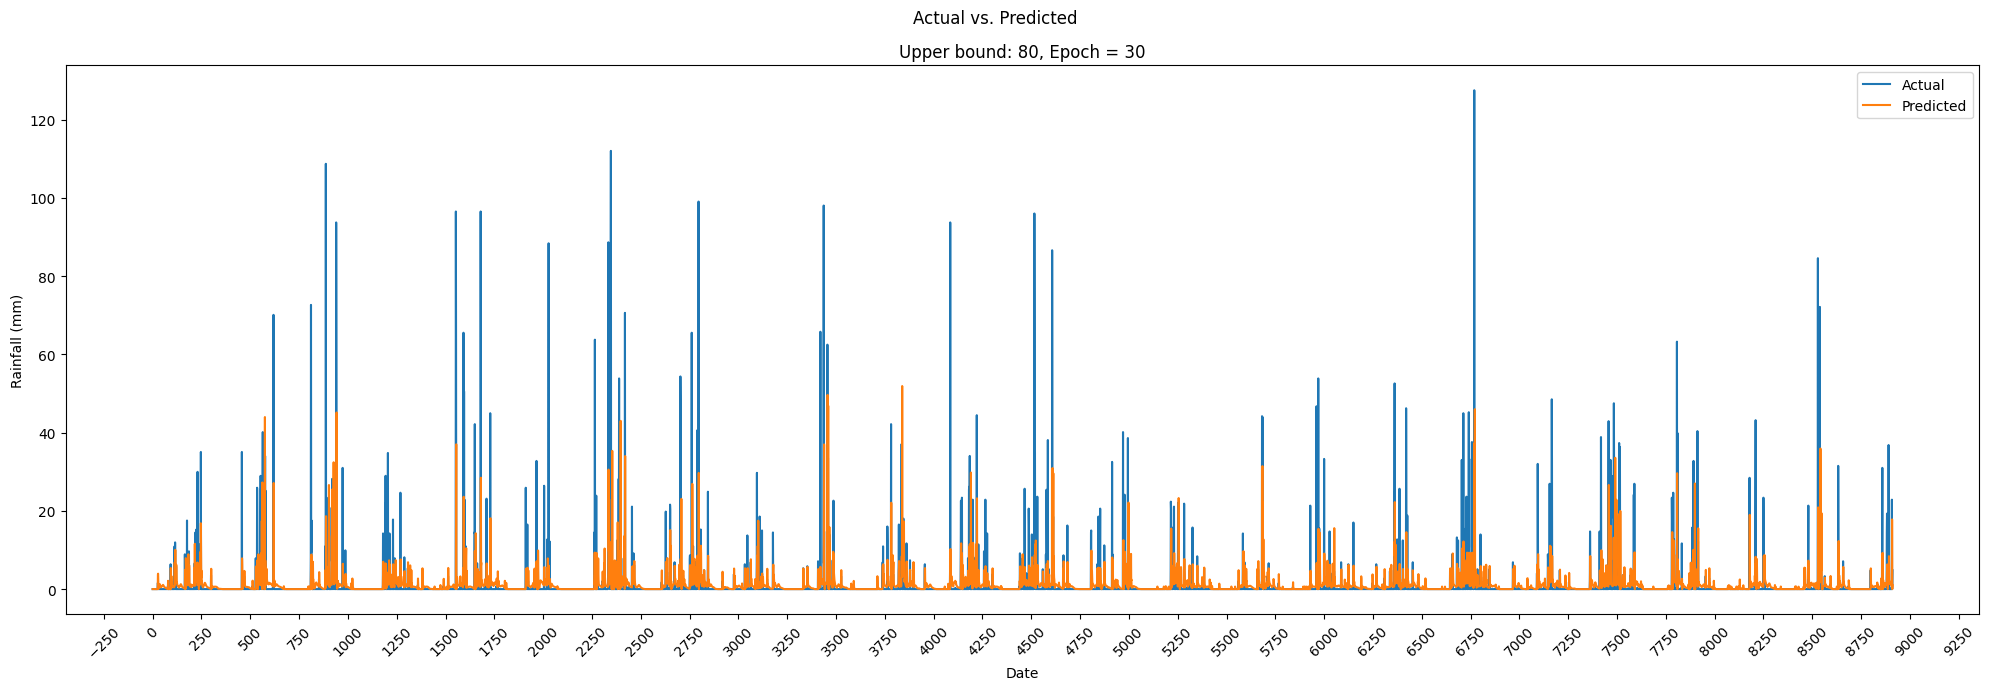

In [23]:
# For upper = 80

# Turn negative prediction to 0
test_compare['Predicted'] = test_compare['Predicted'].clip(lower=0)

plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(test_compare['Actual'])
plt.plot(test_compare['Predicted'])
plt.legend(['Actual', 'Predicted'])
plt.suptitle("Actual vs. Predicted")
plt.title("Upper bound: 80, Epoch = 30")
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()


plt.show()

In [24]:
eval_pred = model.evaluate(test_compare['Actual'],test_compare['Predicted'])
print(f"Loss: {eval_pred[0]}")
print(f"MSE: {eval_pred[1]}")
print(f"AUC: {eval_pred[2]}")

279/279 [==============================] - 1s 3ms/step - loss: 10.0628 - mean_squared_error: 10.0628 - auc: 0.5592
Loss: 10.062776565551758
MSE: 10.062776565551758
AUC: 0.5592309236526489
